In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import Generator
from util import *

plt.rcParams['figure.dpi'] = 150

# Controllable Toonification

- face.pt https://drive.google.com/uc?id=1dOBo4xWUwM7-BwHWZgp-kV1upaD6tHAh
- disney.pt https://drive.google.com/uc?id=1n2uQ5s2XdUBGIcZA9Uabz1mkjVvKWFeG

In [2]:
device = 'mps' #@param ['cuda', 'cpu','mps'] mps for arm structure

generator1 = Generator(256, 512, 8, channel_multiplier=2).eval().to(device)
generator2 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()

mean_latent1 = load_model(generator1, 'Models/face.pt')
mean_latent2 = load_model(generator2, 'Models/disney.pt')

print(len(mean_latent1))
print(mean_latent1[0].shape)

20
torch.Size([1, 512])


## Toonify input face using the reference disney face

- num_swap: determines how many early layers to borrow from input image. This controls how much structure to borrow from input image.
- alpha: controls the degree of toonification.

In [4]:
num_swap =  6
alpha =  0.3

early_alpha = 0

def toonify(latent1, latent2):
    with torch.no_grad():
        noise1 = [getattr(generator1.noises, f'noise_{i}') for i in range(generator1.num_layers)]
        noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

        out1 = generator1.input(latent1[0])
        out2 = generator2.input(latent2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = generator1.conv1(out, latent1[0], noise=noise1[0])
        out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = generator1.to_rgb1(out, latent1[1])
        skip2 = generator2.to_rgb1(out, latent2[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2

        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            generator1.convs[::2], generator1.convs[1::2], noise1[1::2], noise1[2::2], generator1.to_rgbs,
            generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
            out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
            out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, latent1[i], skip)
            skip2 = to_rgb2(out, latent2[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image


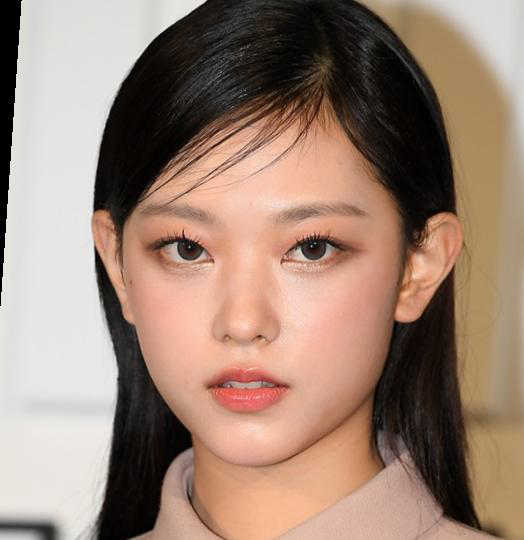

In [7]:
from PIL import Image

Image.open('imgs/crop_Cat.jpg')

/Users/hoon/Desktop/AI/GAN_Model/op/upfirdn2d.py:29: UserWarning: MPS: The constant padding of more than 3 dimensions is not currently supported natively. It uses View Ops default implementation to run. This may have performance implications. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/mps/operations/Pad.mm:393.)
  out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])


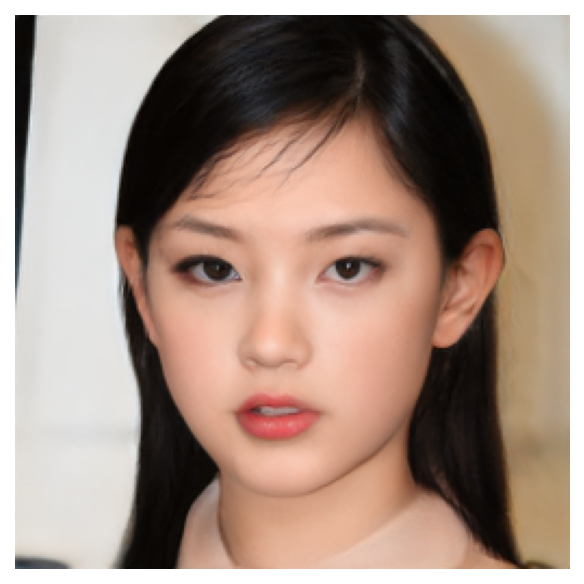

In [5]:
import tensorflow
latent_real = torch.load('inversion_codes/Cat.pt',map_location='mps')['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

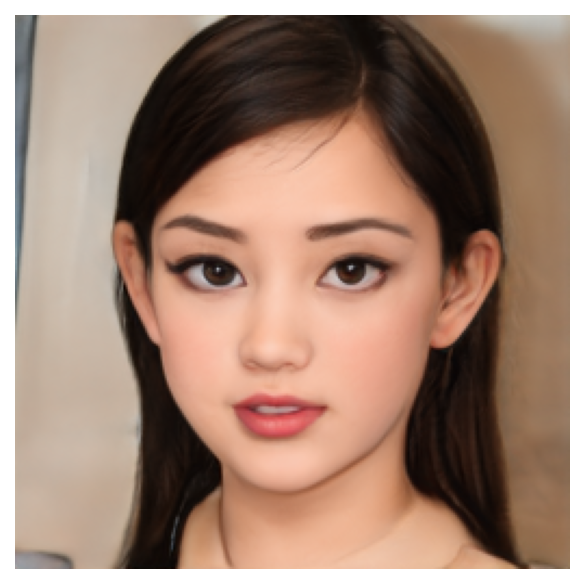

In [6]:
display_image(toonify(latent_real,mean_latent2))